In [1]:
!pip install -q -U torch torchvision torchaudio transformers peft datasets bitsandbytes trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13

In [2]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer

# 1. Configuration
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
dataset_name = "Abirate/english_quotes"
new_model = "TinyLlama-1.1B-Quotes-FinteTuned"

# 2. Load Dataset
dataset = load_dataset(dataset_name, split="train")

# 3. Quantization Config (4-bit)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)

# 4. Load Base Model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# 5. Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

quotes.jsonl:   0%|          | 0.00/647k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2508 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [5]:
from trl import SFTTrainer, SFTConfig
from transformers import TrainingArguments

# 1. LoRA Configuration
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

# 2. SFT Configuration
sft_config = SFTConfig(
    output_dir="./results",
    dataset_text_field="quote",
    max_length=512,              # <--- RENAMED: was max_seq_length
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    packing=False,
)

# 3. Initialize Trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    processing_class=tokenizer,  # <--- RENAMED: was tokenizer
    args=sft_config,
)

# 4. Start Training
trainer.train()

# 5. Save the Fine-Tuned Model
trainer.model.save_pretrained(new_model)


warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Adding EOS to train dataset:   0%|          | 0/2508 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2508 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2508 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Step,Training Loss
25,2.656542
50,2.116368
75,2.347297
100,2.032829
125,2.522040
150,2.200514
175,2.306351
200,2.203016
225,2.382181
250,2.096207


In [6]:
# --- Qualitative Evaluation (Inference) ---

prompt = "Generate a quote about success:"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=100)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

Passing `generation_config` together with generation-related arguments=({'max_length'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


<s>[INST] Generate a quote about success: [/INST] Congreci ““ ““ ““““““ “ ““ “ “ “ ““ ““ “ “““ “ “““ “ ““ ““ ““ “““ “ “ “““ “the “ ““ “ “““““ ““““ ““““ ““““ ““ “ ““ ““““ “ “ “““ “ «


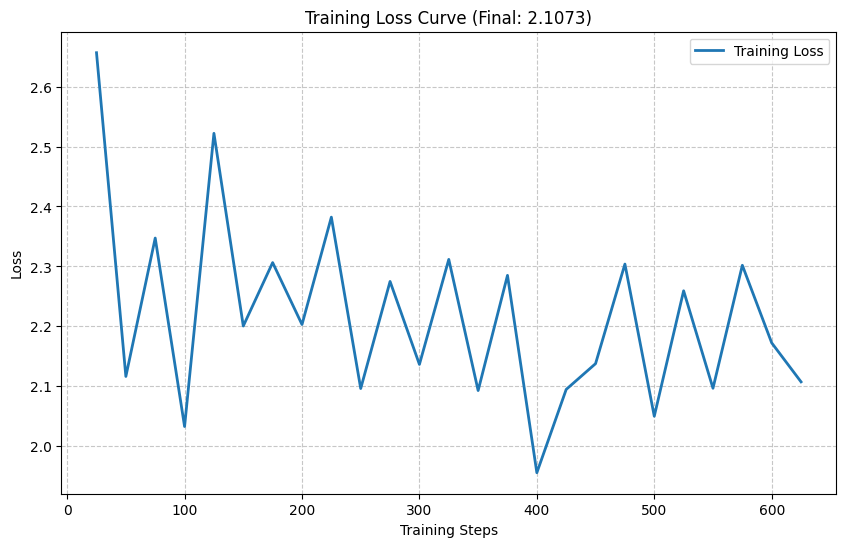


=== Final Model Metrics ===
Final Training Loss: 2.1073
Training Perplexity: 8.2263
(Lower perplexity indicates the model is less 'surprised' by the text)

=== Generation Test ===
Prompt: 'The secret to happiness is'
Result: The secret to happiness is a “““ “ ““ ““ “ “““ ““ “““ “the ““ “ “““ “ ““ ““ “ “the “ “““ ““ ““ “ ““ “““ ““ “““ “


In [9]:
import math
import matplotlib.pyplot as plt
from transformers import pipeline

# --- 1. Extract Metrics from Training Logs ---
# We use the logs already stored in the trainer state
log_history = trainer.state.log_history

# Filter out entries that have loss values
steps = [entry['step'] for entry in log_history if 'loss' in entry]
loss_values = [entry['loss'] for entry in log_history if 'loss' in entry]

if len(loss_values) > 0:
    final_loss = loss_values[-1]
    # Perplexity = exp(Cross Entropy Loss)
    try:
        perplexity = math.exp(final_loss)
    except OverflowError:
        perplexity = float('inf')
else:
    final_loss = 0
    perplexity = 0
    print("Note: No loss logs found yet. Ensure training ran for at least 25 steps.")

# --- 2. Visualize Training Loss ---
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_values, label='Training Loss', color='#1f77b4', linewidth=2)
plt.title(f'Training Loss Curve (Final: {final_loss:.4f})')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# --- 3. Print Quantitative Metrics ---
print("\n=== Final Model Metrics ===")
print(f"Final Training Loss: {final_loss:.4f}")
print(f"Training Perplexity: {perplexity:.4f}")
print("(Lower perplexity indicates the model is less 'surprised' by the text)")

# --- 4. Qualitative Test (Text Generation) ---
print("\n=== Generation Test ===")
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=60,
    truncation=True
)

prompt = "The secret to happiness is"
# We wrap the prompt in the instruction format used by TinyLlama
# (Though for pure quote completion, raw text often works too)
result = pipe(f"{prompt}")

print(f"Prompt: '{prompt}'")
print(f"Result: {result[0]['generated_text']}")